In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from typing import List, Union, Any
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning,ConvergenceWarning


from sklearn import set_config
from sklearn.metrics import root_mean_squared_error as rmse


set_config(
    display='diagram',
    transform_output="pandas"
)


warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
# load data
train_df = pd.read_parquet('./data/train.parquet')
train_df.index = pd.DatetimeIndex(train_df.index).to_period('h')

test_df = pd.read_parquet('./data/test.parquet')
test_df.index = pd.DatetimeIndex(test_df.index).to_period('h')

val_df = pd.read_parquet('./data/val.parquet')
val_df.index = pd.DatetimeIndex(val_df.index).to_period('h')

print(train_df.shape, val_df.shape, test_df.shape)

(24210, 9) (3459, 9) (6918, 9)


## General approach for working with a time series is to:

1. Plotting the series; notice trends and seasonality (we have done this in `data_preparation.ipynb`).
2. Detrend the time series by removing the seasonality and drift.
3. Fit a baseline model and calculate the residual.
4. Diagnose the residual.

## SARIMAX

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is an advanced statistical model used for forecasting time series data that incorporates both seasonal and non-seasonal components, as well as external or exogenous variables that could influence the time series. It extends the ARIMA model by adding seasonality (SARIMA) and the ability to model the impact of independent external variables, making it highly versatile and powerful for handling complex forecasting scenarios. SARIMAX can be decomposed into:

* S: Seasonal

* AR: Autoregressive (p)

* I: Integrated (d)

* MA: Moving Average (q)

* X: Exogeneous variables

### Stationarity test

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions. The target variable must be stationary in this case. There are two tests commonly used in practice:

1. Augmented Dickey Fuller (“ADF”) test.
2. Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test.

### ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understanding if the series is stationary or not. The null and alternate hypothesis of this test are:

$H_0$: the series has a unit root

$H_1$: the series has no unit root

If we fail to reject the null hypothesis, this test may provide evidence that the series is non-stationary. 

* ADF test

In [3]:
full_train_df=pd.concat([train_df, val_df, test_df])

target=full_train_df.Global_active_power

ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")

ADF Statistic: -14.357816480395023
p-value: 9.965088412100937e-27
9.965088412100937e-27 < 0.05 ? True


## Plotting ACF and PACF functions


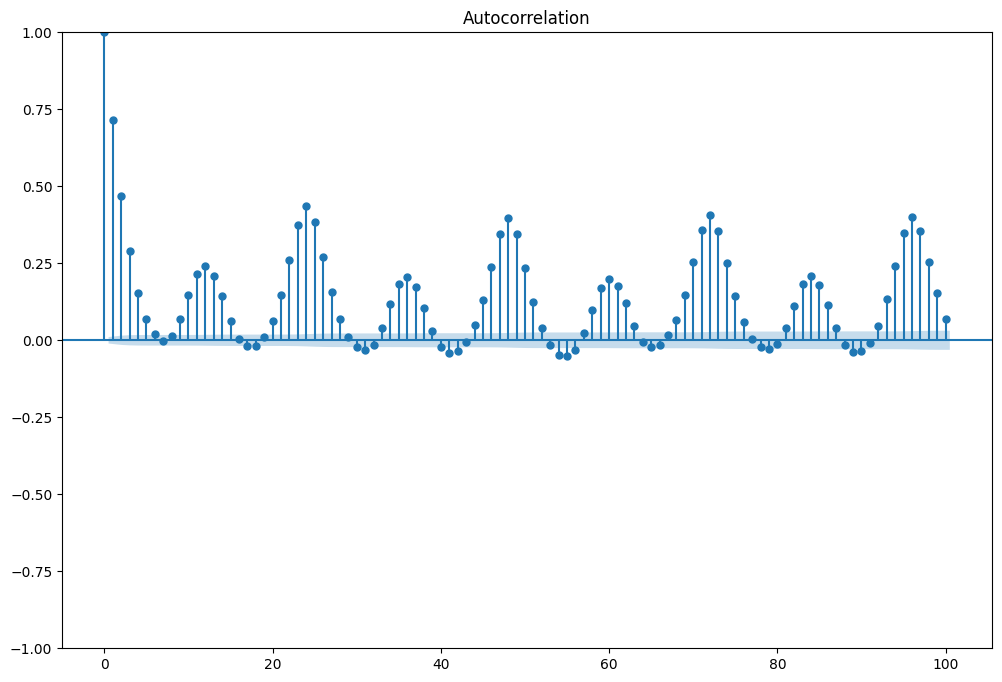

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(target, lags=100, ax=ax)
plt.show()

Our ACF is sinusoidal, meaning that our series is stationary. When we see a sinusoidal pattern in the ACF plot of a stationary process, this is a hint that an autoregressive process is at play, and we must use an AR(p) model to produce our forecast. However, we will have to plot the partial autocorrelation function and see at which lag the coefficients suddenly become non-significant. This lag will be our `p` in AR(p).

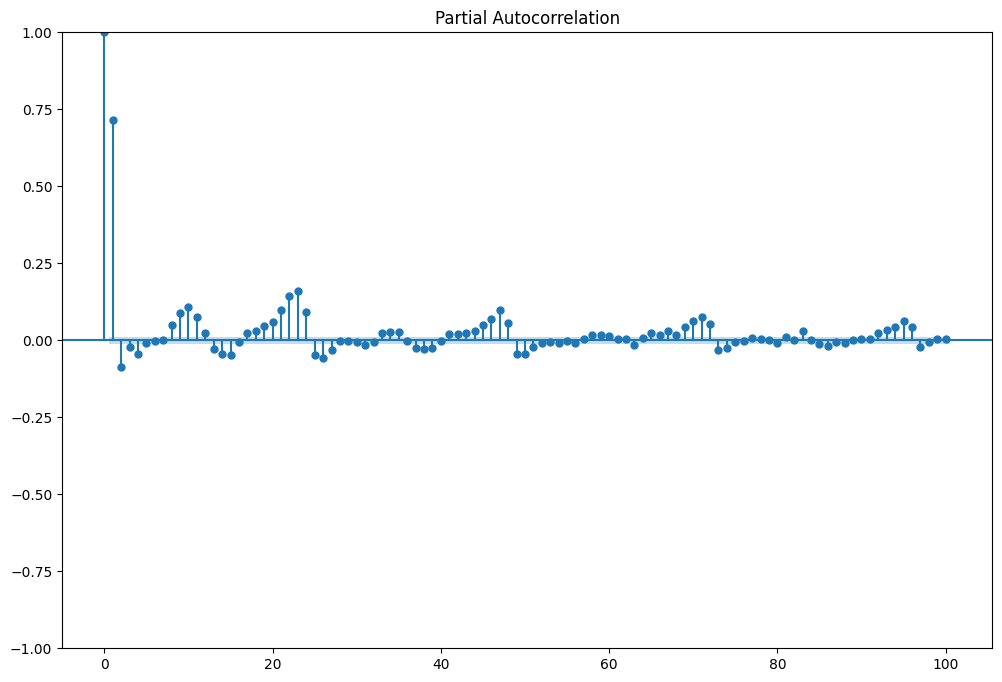

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(target, lags=100, ax=ax)
plt.show()

The PACF plot is also sinusoidal. This indicates no order for the MA(q) or AR(p) process that can be inferred. We are probably in the presence of an ARMA process.

We will list different possible values of p and q (positive integers). With a list of possible values, we can fit every unique combination of ARMA(p,q) to our data. Once that’s done, we can compute the Akaike Information Criterion (AIC), Root Mean Squared Error (RMSE), Coefficient of Determination ($R^2$), Mean Absolute Error (MAE), or other metrics. The model with the best metric is then selected. This is essentially hyperparameter optimization. Note that because our data has a 12 hour seasonal cycle, we will also find optimal values for the seasonal componenets P and Q. Because we did not diffenece to make our series stationary, the D component of our SARIMA will also be 0. In essense, our model is:

$$SARIMA(p,d,q)(P,D,Q)_m = SARIMA(p,0,q)(P,0,Q)_{12}$$ 

I will randomly selected 25 combinations so that the model runs for a reasonable time.


In [6]:
def sarimax_randomized_grid_search(
        train_y: pd.Series,
        train_X: pd.DataFrame,
        valid_y: pd.Series,
        valid_X: pd.DataFrame,
        order_list: List[Any],
        n_iter: int = 25
) -> pd.DataFrame:
    """
    Perform a grid search over ARIMAX hyperparameters on the provided training data.
    
    Parameters
    ----------
    train_y : pd.Series
        The training data (response) for the ARIMAX model.
    train_X : pd.DataFrame
        The training data (predictors) for the ARIMAX model.
    valid_y : pd.Series
        The validation data (response) for the ARIMAX model.
    valid_X : pd.DataFrame
        The validation data (predictors) for the ARIMAX model.
    order_list : List[Any]
        The range of 'p', 'd', 'q', and seasonal parameters to search over.
    n_iter : int
        The number of parameter combinations to try.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing 'p', 'd', 'q', and corresponding metrics (RMSE and AIC) for each combination of hyperparameters.
    """

    random.seed(42)
    sampled_order_list = random.sample(order_list, min(len(order_list), n_iter))

    results = []

    for order in tqdm(sampled_order_list):
        try:
            model = SARIMAX(
                endog=train_y, 
                exog=train_X,
                order=(order[0], 0, order[1]),
                seasonal_order=(order[2], 0, order[3], 12),
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=False
            )
            model_fit = model.fit(disp=False)
            valid_pred = model_fit.predict(start=valid_y.index[0], end=valid_y.index[-1], exog=valid_X)

            aic = model_fit.aic
            rmse_value = rmse(valid_y, valid_pred)
            results.append({
                'order(p, 0, q)(P, 0, Q, 12)': order,
                'AIC': aic,
                'RMSE': rmse_value
            })

        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    results_df = pd.DataFrame(results)

    return results_df


In [7]:
p = range(1, 5, 1)
q = range(1, 5, 1)
P = range(1, 5, 1)
Q = range(1, 5, 1)

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

train_exo, train_endo=train_df.drop('Global_active_power', axis=1), train_df[['Global_active_power']]
val_exo, val_endo=val_df.drop('Global_active_power', axis=1), val_df[['Global_active_power']]
test_exo, test_endo=test_df.drop('Global_active_power', axis=1), test_df[['Global_active_power']]

sarimax_results = sarimax_randomized_grid_search(
    train_y=train_endo,
    train_X=train_exo,
    valid_y=val_endo,
    valid_X=val_exo,
    order_list=parameters_list,
    n_iter=25
)

  0%|          | 0/25 [00:00<?, ?it/s]

  8%|▊         | 2/25 [07:55<1:25:27, 222.95s/it]/home/habeebbabatunde/Time Series/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 3/25 [20:26<2:50:12, 464.22s/it]/home/habeebbabatunde/Time Series/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 16%|█▌        | 4/25 [23:37<2:04:39, 356.17s/it]

In [23]:
?SARIMAX

Init signature:
SARIMAX(
    endog,
    exog=None,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    trend=None,
    measurement_error=False,
    time_varying_regression=False,
    mle_regression=True,
    simple_differencing=False,
    enforce_stationarity=True,
    enforce_invertibility=True,
    hamilton_representation=False,
    concentrate_scale=False,
    trend_offset=1,
    use_exact_diffuse=False,
    dates=None,
    freq=None,
    missing='none',
    validate_specification=True,
    **kwargs,
)
Docstring:     
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
model

Parameters
----------
endog : array_like
    The observed time-series process :math:`y`
exog : array_like, optional
    Array of exogenous regressors, shaped nobs x k.
order : iterable or iterable of iterables, optional
    The (p,d,q) order of the model for the number of AR parameters,
    differences, and MA parameters. `d` must be an integer
    indicating the integration order 